In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

#importing custom functions
import mass_mobil_functions as mmf

sns.set_palette('icefire')


### Case Studies


### Project Contents:
|Name|Description|
|---|---|
|1_EDA_Cleaning|Cleans and merges data from 3 sources. Initial EDA.|
|2_Time_Series_Exploration|Explores some data by country along a time series, and the potential for time series modeling.|
|3_Classification Model|Builds various classification models.|
|4_Visualizations|A visual exploration of the data.|
|data|folder containing csv files of data used|
|streamlit|folder containing streamlit.py file, folder with streamlit images, folder with streamlit data files|


You are currently in notebook 2_Time_Series_Exploration. 

#### Notebook summary: 

For this study I initially had an interest in performing time series analysis by country, as well as by the world as whole. However, I found that there simply wasn't sufficient data to get such a model off the ground. None of the countries necessarily had consistent enough protests recorded for a time series model to be usefel at this time. However, I did decide to take a look at some time series related data for the world by a few specific countries. I wanted to see if there was, perhaps, seasonality to be found. I intend to revisit time series modeling as time allows. 

#### Notebook Table of Contents

* [Plotting Metrics by Country](#plot_by_country)
* [A Description of the Indices/Metrics](#metrics)
* [Cleaning the WorldBank DataBank Data](#clean_wb)
* [Merging and export the data](#merge)


In [5]:
# read in csvs created during eda_cleaning stages in notebook 1.

#World Governance Indicators, to look at change in indicators over time
wgi = pd.read_csv('../data/transformed/wgi_pivot.csv')

#import cleaned FIW data
fiw = pd.read_csv('../data/transformed/fiw_clean.csv')

#fully cleaned and merged df for general exploration
df = pd.read_csv('../data/transformed/mm_wgi_fiw.csv')

#importing cleaned mm data
mm = pd.read_csv('../data/transformed/mass_mobilization_data_cleaned.csv')

### <a name="plot_by_country"></a> Plotting Metrics by Country:
##### A closer look at a few specific countries

Based on exploratory data analysis performed during the cleaning stages, I noted that Mali and Tunisia were the only 2 countries that appeared frequently in the Mass Mobilization dataset and also had visited all 3 'Freedom in the World Scores.' As such, I wanted to take a look at how the World Governance Indicators varied for these countries over time. 

#### <a name="metrics"></a>  A description of the metrics:
|Metric|Description|
|---|---|
|Control of Corruption: Estimate (CC.EST)|Control of Corruption captures perceptions of the extent to which public power is exercised for private gain|
|Government Effectiveness: Estimate (GE.EST)|Government Effectiveness captures perceptions of the quality of public service|
|Political Stability and Absence of Violence/Terrorism: Estimate (PV.EST)|Political Stability and Absence of Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence|
|Rule of Law: Estimate|Rule of Law captures perceptions of the extent to which agents have confidence in and abide by the rules of society|
|Voice and Accountability: Estimate|Voice and Accountability captures perceptions of the extent to which a country\'s citizens are able to participate in selecting their government|
|Number of Protests|Protest count in the given year.|
Freedom in the World Score (FIW)|"Freedom House rates people’s access to political rights and civil liberties in 210 countries and territories through its annual Freedom in the World report. Scores are in 3 tiers: Not Free: 0, Partially Free: 1, Free: 2|

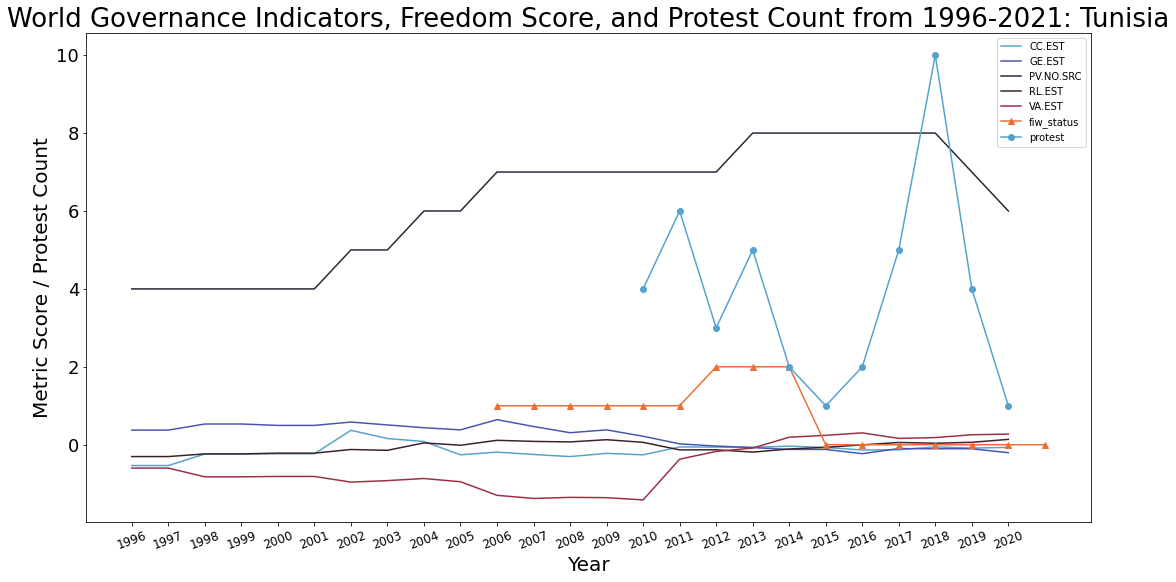

In [6]:
# A custom function to plot metrics from 3 data sources by country.

mmf.time_series_by_country(wgi, fiw, mm, country='Tunisia')

During the EDA phase of this project, I checked to see how many countries had moved around on the Freedom House scale.  In looking specifically at the top 60 countries for frequency in the Mass Mobilization dataset, I found that only 2 countries had transitioned through all three scores, from ‘Not Free’ to ‘Partially Free’ to ‘Free.’

Here we can take a closer look at Tunisia’s metrics over the years. Tunisia was ranked as ‘Partially Free’ from 2006-2011, when it then transitioned to ‘Free,’ where it remained through 2014. This is the period following the ‘Arab Spring.’ 

In 2015 we see a dip in the number of protests corresponding to the drop to ‘Not Free,’ where Tunisia has remained ranked to the present day. We see a spike in the number of protests in 2018, 3 years after the change in rank to ‘Not Free,’ which are noted as pertaining to cost of living and taxes, as well as a notable decrease in the GE.EST score.

Source: https://en.wikipedia.org/wiki/2018_Tunisian_protests


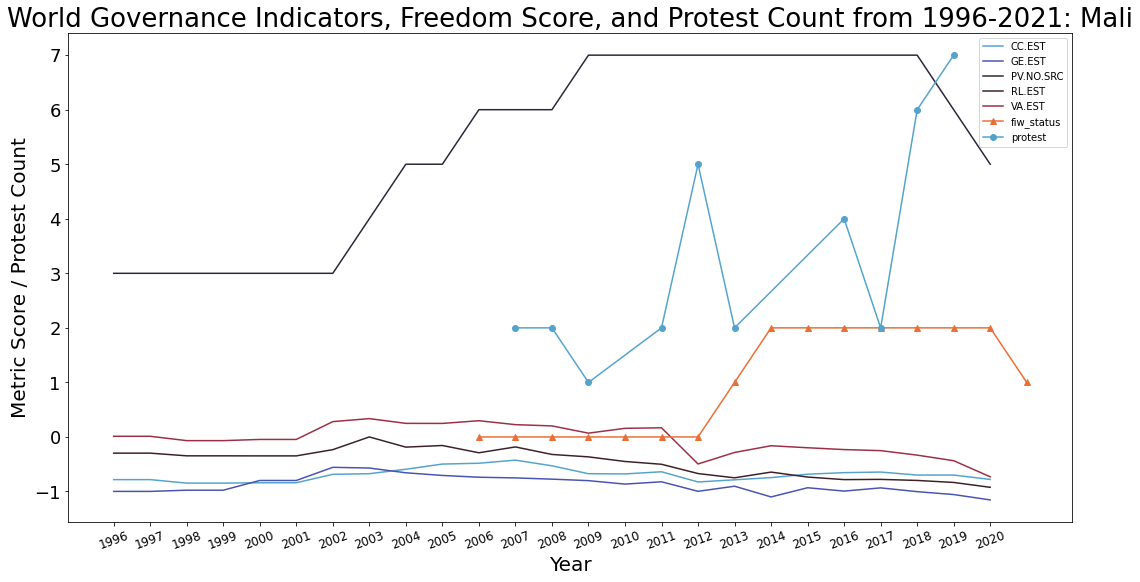

In [7]:
mmf.time_series_by_country(wgi, fiw, mm, country='mali')

In taking a closer look at Mali, we see that it was ranked 'Not Free' until 2012, was upgraded to 'Partially Free' in 2013, and then to 'Free' from 2014-2020. In 2012, just preceding the change to 'Partially Free,' we can not a spoke in number or protests. It doing some light research, we see that Mali experienced a coup in 2012. You can read more about the situation in Mali here: https://freedomhouse.org/country/mali/freedom-world/2021. 

In [15]:
#using custom function to encode/get dummies for columns in preparation for modeling

response_model_df = mmf.categorical_to_encode(df, [], ['fiw_status', 'stateresponse1']).drop(columns='region')
response_model_df.head(3)

,country_name,ccode,year,protest,protestnumber,protesterviolence,participants_category,start_date,end_date,duration,...,VA.EST,NF,PF,arrests,beatings,crowd dispersal,ignore,killings,shootings,unknown
0,Canada,20,2006,1,1,1,3,2006-02-21,2006-08-17,178 days,...,1.415595,0,0,0,0,1,0,0,0,0
1,Canada,20,2007,1,1,0,5,2007-06-29,2007-06-29,1 days,...,1.384672,0,0,0,0,0,1,0,0,0
2,Canada,20,2008,1,1,1,3,2008-08-10,2008-08-10,1 days,...,1.407529,0,0,0,0,1,0,0,0,0


In [16]:
tunisia = response_model_df[response_model_df['country_name'] == 'Tunisia']
tunisia.head(3)

,country_name,ccode,year,protest,protestnumber,protesterviolence,participants_category,start_date,end_date,duration,...,VA.EST,NF,PF,arrests,beatings,crowd dispersal,ignore,killings,shootings,unknown
5678,Tunisia,616,2010,1,1,1,2,2010-12-17,2010-12-26,10 days,...,-1.416165,1,0,0,0,0,0,0,1,0
5679,Tunisia,616,2010,1,2,1,1,2010-12-17,2011-01-15,30 days,...,-1.416165,1,0,0,1,0,0,0,0,0
5680,Tunisia,616,2010,1,3,1,5,2010-12-24,2010-12-31,8 days,...,-1.416165,1,0,0,0,0,0,0,1,0


In [13]:
month = tunisia.resample('M').sum()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [ ]:
month.shape

(168, 33)

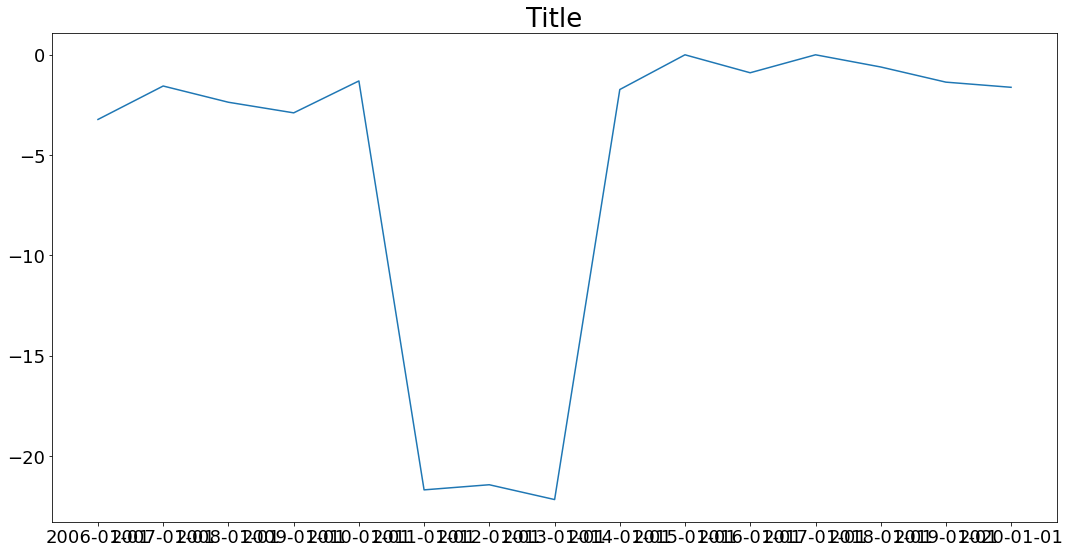

In [ ]:
plot_series(kyrgyz_df.resample('YS').sum(), cols=['GE.EST'])

In [206]:
month['first_diff_ge'] = month['GE.EST'].diff(1)
month['annual_diff_ge'] = month['GE.EST'].diff(12)

In [207]:
month.isna().sum()

protest                         0
protestnumber                   0
protesterviolence               0
participants_category           0
duration_int                    0
labor wage dispute              0
land farm issue                 0
police brutality                0
political behavior, process     0
price increases, tax policy     0
removal of politician           0
social restrictions             0
CC.EST                          0
GE.EST                          0
PV.NO.SRC                       0
RL.EST                          0
VA.EST                          0
NF                              0
PF                              0
Asia                            0
Central America                 0
Europe                          0
MENA                            0
North America                   0
Oceania                         0
South America                   0
arrests                         0
beatings                        0
crowd dispersal                 0
ignore        

In [208]:
month.dropna().shape

(156, 35)

In [209]:
features = month.drop(columns=['annual_diff_ge', 'first_diff_ge']).columns
y = month['annual_diff_ge']
X = month[features]

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                  test_size= 0.1,
                                  shuffle=False)

In [211]:
import warnings

In [212]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [213]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,1,0) is: 424.04235150061623
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,1,1) is: 402.3450820327531
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,1,2) is: 389.7589738219931
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,1,3) is: 390.67087667788337
Attempting to fit ARIMA(0,1,4)
The AIC for ARIMA(0,1,4) is: 387.31069765383296
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,1,0) is: 419.4117141000221
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,1,1) is: 390.77831254498665
Attempting to fit ARIMA(1,1,2)


/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(1,1,2) is: 391.1923948178873
Attempting to fit ARIMA(1,1,3)
The AIC for ARIMA(1,1,3) is: 390.08195567598943
Attempting to fit ARIMA(1,1,4)
The AIC for ARIMA(1,1,4) is: 388.9110860238361
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,1,0) is: 411.0277112464412
Attempting to fit ARIMA(2,1,1)
The AIC for ARIMA(2,1,1) is: 390.3129034353336
Attempting to fit ARIMA(2,1,2)


/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(2,1,2) is: 380.29639756592195
Attempting to fit ARIMA(2,1,3)
The AIC for ARIMA(2,1,3) is: 386.6251862475066
Attempting to fit ARIMA(2,1,4)
The AIC for ARIMA(2,1,4) is: 387.26467403251365
Attempting to fit ARIMA(3,1,0)
The AIC for ARIMA(3,1,0) is: 401.6900322913518
Attempting to fit ARIMA(3,1,1)
The AIC for ARIMA(3,1,1) is: 391.48448571129313
Attempting to fit ARIMA(3,1,2)
The AIC for ARIMA(3,1,2) is: 393.078345649399
Attempting to fit ARIMA(3,1,3)


/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,3) is: 386.6117837255158
Attempting to fit ARIMA(3,1,4)


/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,4) is: 388.8504207534694
Attempting to fit ARIMA(4,1,0)
The AIC for ARIMA(4,1,0) is: 402.28388972898523
Attempting to fit ARIMA(4,1,1)
The AIC for ARIMA(4,1,1) is: 393.482261496388
Attempting to fit ARIMA(4,1,2)
The AIC for ARIMA(4,1,2) is: 395.0097826674935
Attempting to fit ARIMA(4,1,3)
The AIC for ARIMA(4,1,3) is: 388.8217864361627
Attempting to fit ARIMA(4,1,4)
The AIC for ARIMA(4,1,4) is: 390.66304218659633


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,2).
This model has an AIC of 380.29639756592195.


/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Our model that minimizes AIC on the training data is the ARIMA(2,1,2).
This model has an AIC of 382.29625037454923.


In [29]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (2,1,2))

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])





/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
mean_squared_error(y_test, preds)**.5

0.4249264917044401

In [32]:
r2_score(y_test, preds)

-0.005600576200489149

In [33]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


In [35]:
df.head(3)

,country_name,ccode,year,region,protest,protestnumber,protesterviolence,participants_category,stateresponse1,start_date,...,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,CC.EST,GE.EST,PV.NO.SRC,RL.EST,VA.EST,fiw_status
0,Canada,20,2006,North America,1,1,1,3,crowd dispersal,2006-02-21,...,1,0,0,0,1.962554,1.895545,8.0,1.814535,1.415595,F
1,Canada,20,2007,North America,1,1,0,5,ignore,2007-06-29,...,1,0,0,0,2.000900,1.761394,8.0,1.814706,1.384672,F
2,Canada,20,2008,North America,1,1,1,3,crowd dispersal,2008-08-10,...,0,0,0,0,2.002689,1.791681,8.0,1.808290,1.407529,F


In [37]:
fiw_target_df = categorical_to_encode(df, ['fiw_status'], ['region', 'stateresponse1'])

In [56]:
fiw_kyrgyz_df = time_series_by_country(fiw_target_df, 'Kyrgyzstan')

In [60]:
fiw_kyrgyz_df.columns

Index(['protest', 'protestnumber', 'protesterviolence',
       'participants_category', 'duration_int', 'labor wage dispute',
       'land farm issue', 'police brutality', 'political behavior, process',
       'price increases, tax policy', 'removal of politician',
       'social restrictions', 'CC.EST', 'GE.EST', 'PV.NO.SRC', 'RL.EST',
       'VA.EST', 'fiw_status', 'Asia', 'Central America', 'Europe', 'MENA',
       'North America', 'Oceania', 'South America', 'arrests', 'beatings',
       'crowd dispersal', 'ignore', 'killings', 'shootings', 'unknown'],
      dtype='object')

In [61]:
features = fiw_kyrgyz_df.drop(columns = ['GE.EST']).columns
y = fiw_kyrgyz_df['fiw_status']
X = fiw_kyrgyz_df[features]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=True)

In [64]:
svr = SVR(gamma = 'scale', kernel = 'linear', C=10, epsilon=.05)
ridge = Ridge(random_state = 48, tol=1e-3, normalize=False, solver='auto')
neighbor = KNeighborsRegressor(n_neighbors = 5)
linreg = LinearRegression()

In [65]:
svr_yhat, ridge_yhat, neighbor_yhat, linreg_yhat = [], [], [], []

In [66]:
models_dict = {'SVR' : [svr, svr_yhat], 
                'Ridge' : [ridge, ridge_yhat],  
                'KNN' : [neighbor, neighbor_yhat], 
                'Linear Regression' : [linreg, linreg_yhat]}

In [67]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [68]:
tree.score(X_train, y_train)

1.0

In [69]:
tree.score(X_test, y_test)

1.0